# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys

In [2]:
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")


# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "housematerial"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 50
    # TRAIN_ROIS_PER_IMAGE = 20

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("housematerial", 1, "glass")
        self.add_class("housematerial", 2, "brick")
        self.add_class("housematerial", 3, "stone")
        self.add_class("housematerial", 4, "timber")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 
                class_id = [r['region_attributes'] for r in a['regions']]
                
            class_ids = []
            
            for clas in class_id:
                if clas: 
                    if clas['material'] == 'glass':
                        class_ids.append(1)
                    if clas['material'] == 'brick':
                        class_ids.append(2)
                    if clas['material'] == 'stone':
                        class_ids.append(3)
                    if clas['material'] == 'timber':
                        class_ids.append(4)

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                "housematerial",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        ##############
        #print(image_info["source"])
        if image_info["source"] != "housematerial" :
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        class_ids = np.array(info['class_ids'], dtype=np.int32)
        
        for (i, p), c in zip(enumerate(info["polygons"]),class_ids) :
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = c
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        
        return mask.astype(np.bool), class_ids
    
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "housematerial":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
import json
import skimage.draw
# Training dataset.
dataset_train = BalloonDataset()
dataset_train.load_balloon("../../dataset","train")
dataset_train.prepare()

# Validation dataset
dataset_val = BalloonDataset()
dataset_val.load_balloon("../../dataset","val")
dataset_val.prepare()


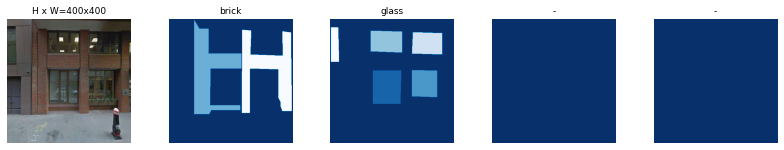

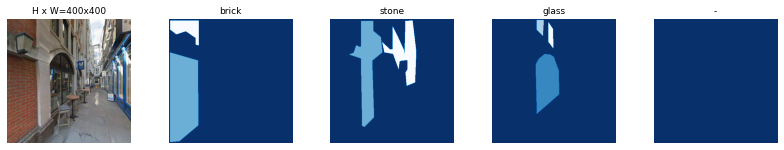

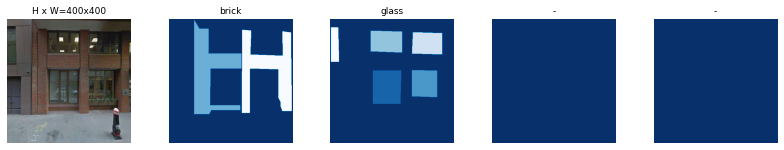

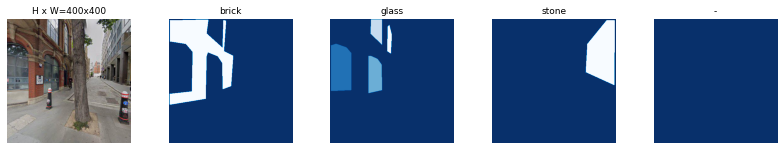

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)
#model = modellib.MaskRCNN(mode="training", config=config,
                      #    model_dir=MODEL_DIR)
    
model_inference = modellib.MaskRCNN(mode="inference", 
                                    config=config,
                                    model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 20


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model,
model_inference, dataset_val, calculate_map_at_every_X_epoch=5, verbose=1)


In [11]:

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads',
           custom_callbacks=[mean_average_precision_callback])


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jupyter/Mask_RCNN/logs/housematerial20210415T2000/mask_rcnn_housematerial_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker



Epoch 1/20
100/100 [==============================] - 155s 2s/step - loss: 2.9032 - rpn_class_loss: 0.2319 - rpn_bbox_loss: 0.5401 - mrcnn_class_loss: 0.6767 - mrcnn_bbox_loss: 0.6896 - mrcnn_mask_loss: 0.7649 - val_loss: 2.9566 - val_rpn_class_loss: 0.3789 - val_rpn_bbox_loss: 0.8404 - val_mrcnn_class_loss: 0.5931 - val_mrcnn_bbox_loss: 0.6092 - val_mrcnn_mask_loss: 0.5351
Epoch 2/20
100/100 [==============================] - 105s 1s/step - loss: 2.5655 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.6080 - mrcnn_class_loss: 0.7136 - mrcnn_bbox_loss: 0.5641 - mrcnn_mask_loss: 0.6128 - val_loss: 2.0664 - val_rpn_class_loss: 0.0805 - val_rpn_bbox_loss: 0.5720 - val_mrcnn_class_loss: 0.4561 - val_mrcnn_bbox_loss: 0.5193 - val_mrcnn_mask_loss: 0.4384
Epoch 3/20
100/100 [==============================] - 105s 1s/step - loss: 2.5043 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 0.6887 - mrcnn_class_loss: 0.6477 - mrcnn_bbox_loss: 0.4928 - mrcnn_mask_loss: 0.5693 - val_loss: 2.0865 - val_rpn_class

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


 56/100 [===============>..............] - ETA: 44s - loss: 2.4529 - rpn_class_loss: 0.1137 - rpn_bbox_loss: 0.7488 - mrcnn_class_loss: 0.6192 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.5112

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


 57/100 [================>.............] - ETA: 43s - loss: 2.4398 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.6168 - mrcnn_bbox_loss: 0.4572 - mrcnn_mask_loss: 0.5087

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


 59/100 [================>.............] - ETA: 41s - loss: 2.4884 - rpn_class_loss: 0.1236 - rpn_bbox_loss: 0.7691 - mrcnn_class_loss: 0.6234 - mrcnn_bbox_loss: 0.4617 - mrcnn_mask_loss: 0.5105

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


100/100 [==============================] - 104s 1s/step - loss: 2.3688 - rpn_class_loss: 0.1287 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.6014 - mrcnn_bbox_loss: 0.4545 - mrcnn_mask_loss: 0.5007 - val_loss: 2.2932 - val_rpn_class_loss: 0.1413 - val_rpn_bbox_loss: 0.5374 - val_mrcnn_class_loss: 0.7312 - val_mrcnn_bbox_loss: 0.4690 - val_mrcnn_mask_loss: 0.4142
Epoch 5/20
100/100 [==============================] - 104s 1s/step - loss: 2.1913 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.5718 - mrcnn_class_loss: 0.6439 - mrcnn_bbox_loss: 0.4256 - mrcnn_mask_loss: 0.4965 - val_loss: 2.4016 - val_rpn_class_loss: 0.0598 - val_rpn_bbox_loss: 1.0671 - val_mrcnn_class_loss: 0.5172 - val_mrcnn_bbox_loss: 0.3885 - val_mrcnn_mask_loss: 0.3690
Calculating mAP...
Loaded weights for the inference model (last checkpoint of the train model): /home/jupyter/Mask_RCNN/logs/housematerial20210415T2000/mask_rcnn_housematerial_0005.h5
Re-starting from epoch 5
mAP at epoch 5 is: 0.1627589265767465
Epoch 6/20

In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all",
            custom_callbacks=[mean_average_precision_callback])


Starting at epoch 20. LR=0.0001

Checkpoint Path: /home/jupyter/Mask_RCNN/logs/housematerial20210415T2000/mask_rcnn_housematerial_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker



Epoch 21/40
100/100 [==============================] - 249s 2s/step - loss: 1.7059 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 0.5351 - mrcnn_class_loss: 0.4646 - mrcnn_bbox_loss: 0.3237 - mrcnn_mask_loss: 0.3268 - val_loss: 2.2345 - val_rpn_class_loss: 0.1371 - val_rpn_bbox_loss: 0.5881 - val_mrcnn_class_loss: 0.7809 - val_mrcnn_bbox_loss: 0.3645 - val_mrcnn_mask_loss: 0.3639
Epoch 22/40
100/100 [==============================] - 171s 2s/step - loss: 1.9537 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 0.6734 - mrcnn_class_loss: 0.5280 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.3426 - val_loss: 2.1249 - val_rpn_class_loss: 0.1400 - val_rpn_bbox_loss: 0.4710 - val_mrcnn_class_loss: 0.6421 - val_mrcnn_bbox_loss: 0.4347 - val_mrcnn_mask_loss: 0.4371
Epoch 23/40
100/100 [==============================] - 171s 2s/step - loss: 1.4819 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.4463 - mrcnn_class_loss: 0.4165 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.3069 - val_loss: 1.5002 - val_rpn_cl

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


 24/100 [======>.......................] - ETA: 2:07 - loss: 1.8126 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.4619 - mrcnn_class_loss: 0.5425 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.3819

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


 26/100 [======>.......................] - ETA: 2:04 - loss: 1.7864 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.5363 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.3808

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


 27/100 [=======>......................] - ETA: 2:02 - loss: 1.7826 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.5350 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.3924

ERROR:root:Error processing image {'id': 'Km4SscLpj4nWrrGopYPeqg_0.jpg', 'source': 'housematerial', 'path': '../../dataset/train/Km4SscLpj4nWrrGopYPeqg_0.jpg', 'width': 400, 'height': 400, 'polygons': [{'name': 'rect', 'x': 3, 'y': 1, 'width': 391, 'height': 393}], 'class_ids': [2]}
Traceback (most recent call last):
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1712, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/jupyter/Mask_RCNN/mrcnn/model.py", line 1215, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e2d626f1ada9>", line 105, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
KeyError: 'all_points_y'


100/100 [==============================] - 172s 2s/step - loss: 1.6024 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.4328 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 0.3538 - val_loss: 1.3088 - val_rpn_class_loss: 0.0514 - val_rpn_bbox_loss: 0.4481 - val_mrcnn_class_loss: 0.3521 - val_mrcnn_bbox_loss: 0.2380 - val_mrcnn_mask_loss: 0.2192
Epoch 30/40
100/100 [==============================] - 172s 2s/step - loss: 1.7826 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4898 - mrcnn_bbox_loss: 0.3196 - mrcnn_mask_loss: 0.3598 - val_loss: 2.1697 - val_rpn_class_loss: 0.1405 - val_rpn_bbox_loss: 0.7351 - val_mrcnn_class_loss: 0.5403 - val_mrcnn_bbox_loss: 0.3717 - val_mrcnn_mask_loss: 0.3821
Calculating mAP...
Loaded weights for the inference model (last checkpoint of the train model): /home/jupyter/Mask_RCNN/logs/housematerial20210415T2000/mask_rcnn_housematerial_0030.h5
Re-starting from epoch 30
mAP at epoch 30 is: 0.25332957898074565
Epoch 

In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [13]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/Mask_RCNN/logs/housematerial20210415T2000/mask_rcnn_housematerial_0040.h5
Re-starting from epoch 40


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:  116.00000  max:  910.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


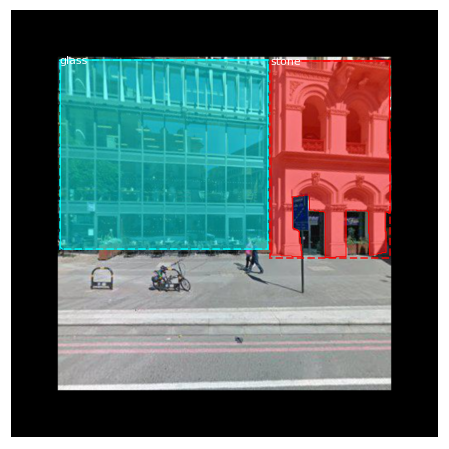

In [117]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


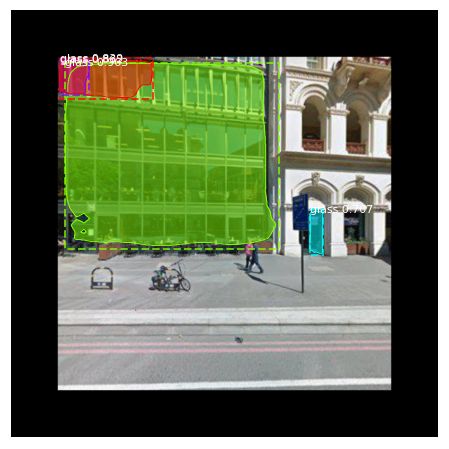

In [118]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [121]:
print(r['class_ids'])
print(original_image)

[1 1 1 1]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


## Evaluation

In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4052870237438518


## Detection All

In [142]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/Mask_RCNN/logs/housematerial20210415T2000/mask_rcnn_housematerial_0040.h5
Re-starting from epoch 40


In [152]:
original_images=[]
folder = "/home/jupyter/Mask_RCNN/dataset/detect"
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        original_images.append(img)

In [ ]:
results = []
for image in original_images:
    result = model.detect([image], verbose=0)
    r = result[0]
    results.append(r['class_ids'])
#results
image.id

In [170]:
statis = []
for i in results:
    dict = {}
    dict[1] = 0
    dict[2] = 0
    dict[3] = 0
    dict[4] = 0
    for key in i:
        dict[key] = dict.get(key, 0) + 1
    statis.append(dict)
statis
import pandas as pd
dt_statis = pd.DataFrame(statis)
dt_statis

,1,2,3,4
0,3,2,0,0
1,5,2,0,0


In [ ]:
dt_statis.to_excel('statis.xlsx')

## Calculate individual mask area